How to test:
1. Run data_processing.ipynb -> It'll create a folder name data with a csv file per company
2. Run all in this file, if you want to test data you run the only last cell

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

FEATURE_COLUMNS = [
    "year", "month", "intrinsic_value", "stock_exret", "stock_ticker", "comp_name", "be_me", "ni_me", "fcf_me",
    "betadown_252d", "ni_ar1", "z_score", "ebit_sale", "at_turnover",
    "market_equity", "roic", "bvps", "prev_bvps", "bvps_change", "prev_at_turnover",
    "at_turnover_change", "prev_ni_me", "ni_me_change", "prev_fcf_me", "fcf_me_change",
    "sin_month", "cos_month"
] # 27 - 4 = 23
# ignore stock_ticker, comp_name, year, month, ni_me_change, fcf_me_change

SEQ_LENGTH = 12

In [2]:
def process_time_features(df):
    """ Remove `year`, and encode `month` cyclically """
    if "year" not in df.columns or "month" not in df.columns:
        raise KeyError("The dataset does not contain 'year' or 'month' columns.")

    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
    return df
    # return df.drop(columns=["year", "month"])  # Remove original time columns

In [3]:
def normalize_features(df):
    print(df)
    feature_columns = [col for col in df.columns if col not in ["year", "month", "stock_exret"]]

    # Identify non-numeric columns
    # non_numeric_cols = df[feature_columns].select_dtypes(exclude=[np.number]).columns.tolist()
    # if non_numeric_cols:
    #     print("Dropping non-numeric columns:", non_numeric_cols)
    #     df = df.drop(columns=non_numeric_cols)

    # Replace NaN and infinite values
    # df[feature_columns] = df[feature_columns].replace([np.inf, -np.inf], np.nan)  # Convert inf to NaN
    # # Check for infinity values
    # print("Has Inf values:\n", df.isin([np.inf, -np.inf]).sum())

    df[feature_columns] = df[feature_columns].fillna(0)  # Replace NaN with 0

    # Normalize using MinMaxScaler
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    return df

In [4]:
def load_company_data(company):
    file_path = f"data/{company}.csv"

    if not os.path.exists(file_path):
        print(f"Skipping {company} (No data found)")
        return None, None, None

    df = pd.read_csv(file_path)

    # Drop unnecessary columns
    df = df.drop(columns=["stock_ticker", "comp_name", "ni_me_change", "fcf_me_change",
        "prev_intrinsic_value","next_intrinsic_value","prev_stock_exret","next_stock_exret",
        "prev_be_me", "next_be_me","prev_ni_me","next_ni_me","prev_fcf_me","next_fcf_me",
        "prev_betadown_252d","next_betadown_252d","prev_ni_ar1","next_ni_ar1","prev_z_score",
        "next_z_score","prev_ebit_sale","next_ebit_sale","prev_at_turnover","next_at_turnover",
        "prev_market_equity","next_market_equity","prev_bvps","next_bvps"], errors="ignore")

    # Fill NaN values
    df = df.fillna(0)

    # Normalize feature columns (excluding year, month, and stock_exret)
    feature_columns = [col for col in df.columns if col not in ["year", "month", "stock_exret"]]
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    # Split data into training and validation sets
    df_train = df[df["year"] < 2022]  # Training: 2000–2021
    df_val = df[df["year"] == 2022]   # Validation: 2022
    df_test = df[df["year"] == 2023]  # Test: 2023 (for final prediction)

    return df_train, df_val, df_test


In [6]:
def create_lstm_sequences(df, seq_length, company_id):
    """
    Converts dataframe into LSTM sequences for training only.
    Uses a rolling window approach: each sequence consists of `seq_length` months,
    and the next month's value is the target.
    """
    X_seq, Y_seq, company_ids_seq = [], [], []

    # df = df[df['year'] == 2022]
    # df = df[df['year'].isin([2022, 2023])]

    df = df.drop(columns=['year', 'month'])
    print(df)

    df_values = df.values  
    num_samples = len(df_values)

    for i in range(num_samples - seq_length):
        x_seq = df_values[i:i + seq_length]  
        y_target = df_values[i + seq_length][0]  

        X_seq.append(x_seq)
        Y_seq.append(y_target)
        company_ids_seq.append(company_id)

    return np.array(X_seq), np.array(Y_seq), np.array(company_ids_seq)

In [60]:
print(model)

StockLSTM(
  (embedding): Embedding(547, 33)
  (lstm): LSTM(48, 64, num_layers=2, batch_first=True, dropout=0.2)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [61]:
pip install torchinfo


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
from torchinfo import summary

model = StockLSTM(input_size, hidden_size, num_layers, output_size, len(company_files), embedding_dim, num_heads, dropout=0.2).to(device)

# Correct input dimensions: (batch_size, seq_length, input_size) for `x`
# and (batch_size,) for `company_ids`
summary(model, input_data=[torch.randn(batch_size, seq_length, input_size).to(device), 
                           torch.randint(0, len(company_files), (batch_size,)).to(device)], 
        col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
StockLSTM                                [256, 5, 15]              [256, 1]                  --
├─Embedding: 1-1                         [256]                     [256, 33]                 18,051
├─LSTM: 1-2                              [256, 5, 48]              [256, 5, 64]              62,464
├─MultiheadAttention: 1-3                [5, 256, 64]              [5, 256, 64]              16,640
├─Dropout: 1-4                           [256, 5, 64]              [256, 5, 64]              --
├─Linear: 1-5                            [256, 64]                 [256, 1]                  65
Total params: 97,220
Trainable params: 97,220
Non-trainable params: 0
Total mult-adds (M): 84.59
Input size (MB): 0.08
Forward/backward pass size (MB): 0.72
Params size (MB): 0.32
Estimated Total Size (MB): 1.13

In [ ]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_companies, embedding_dim, num_heads, dropout=0.2):
        super(StockLSTM, self).__init__()
        
        self.input_size = input_size

        # Company embedding layer
        self.embedding = nn.Embedding(num_companies, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size + embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=dropout)

        # Dropout layer before the final output layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, company_ids):
        # Convert company IDs to embeddings
        company_embedding = self.embedding(company_ids).unsqueeze(1)  # (batch, 1, embedding_dim)
        company_embedding = company_embedding.expand(-1, x.shape[1], -1)  # Repeat across time steps

        

        # Concatenate embeddings with financial data
        x = torch.cat((x, company_embedding), dim=2)
        # print(f"Model forward input shape: {x.shape}")  # (batch, seq_length, input_size)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        lstm_out = lstm_out.permute(1, 0, 2)
        attn_output, _ = self.attn(lstm_out, lstm_out, lstm_out)
        attn_output = attn_output.permute(1, 0, 2)
        attn_output = self.dropout(attn_output)

        # Use last time step's output for prediction
        output = self.fc(attn_output[:, -1, :])

        return output

In [41]:
company_files = [f.split(".csv")[0] for f in os.listdir("data") if f.endswith(".csv")]  # 2501 companies
print(len(company_files))
company_to_id = {comp: idx for idx, comp in enumerate(company_files)}
print(company_to_id)

# Hyperparameters
num_epochs = 100
batch_size = 256
feature_input_size = len(FEATURE_COLUMNS)  # This should match actual features before embedding
embedding_dim = 33  # sqrt(num_companies) 547 companies
input_size = 15  # feature_input_size(17) + embedding_dim(24) = 41
seq_length = 5
num_heads = 8

hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001

547
{'CSCO': 0, 'PRI': 1, 'UAL': 2, 'TROW': 3, 'ISRG': 4, 'NVR': 5, 'LECO': 6, 'TPR': 7, 'DVN': 8, 'CE': 9, 'NBIX': 10, 'BA': 11, 'VRTX': 12, 'AFG': 13, 'BRK.B': 14, 'GILD': 15, 'MDU': 16, 'MKL': 17, 'HUN': 18, 'TER': 19, 'PODD': 20, 'V': 21, 'QRVO': 22, 'CIEN': 23, 'A': 24, 'MO': 25, 'SWKS': 26, 'MCHP': 27, 'CDNS': 28, 'MSCI': 29, 'CHTR': 30, 'EIX': 31, 'BBY': 32, 'PEGA': 33, 'WBA': 34, 'LVS': 35, 'HCA': 36, 'AJG': 37, 'DTE': 38, 'AN': 39, 'C': 40, 'GWRE': 41, 'BRK.A': 42, 'FAF': 43, 'T': 44, 'CF': 45, 'MGM': 46, 'JLL': 47, 'HUM': 48, 'OSK': 49, 'DAR': 50, 'DLB': 51, 'WU': 52, 'APH': 53, 'ARW': 54, 'SYY': 55, 'MSI': 56, 'BC': 57, 'FCX': 58, 'ADM': 59, 'LH': 60, 'GGG': 61, 'WLK': 62, 'LNT': 63, 'LNC': 64, 'PSX': 65, 'PPC': 66, 'GPN': 67, 'HUBB': 68, 'PPG': 69, 'TECH': 70, 'IQV': 71, 'LNG': 72, 'NOV': 73, 'TNET': 74, 'HAL': 75, 'STZ': 76, 'FLS': 77, 'DXC': 78, 'MSM': 79, 'ADI': 80, 'F': 81, 'HOG': 82, 'ADBE': 83, 'CHH': 84, 'DCI': 85, 'STLD': 86, 'CPRT': 87, 'TDG': 88, 'TFX': 89, 'XPO':

In [ ]:
# Combine data from all companies
all_X_train, all_Y_train, all_company_train = [], [], []
all_X_val, all_Y_val, all_company_val = [], [], []

for company in company_files:
    company_id = company_to_id[company]
    print(f"Processing {company}...")

    df_train, df_val, df_test = load_company_data(company)

    if df_train is None or df_val is None:
        continue
    #  intrinsic_value  stock_exret     be_me     ni_me    fcf_me
    #  betadown_252d    ni_ar1   z_score  ebit_sale  at_turnover  market_equity
    #  roic          bvps  bvps_change  at_turnover_change  sin_month  cos_month (17 columns)

    # Create sequences for training & validation
    X_train, Y_train, company_train = create_lstm_sequences(df_train, seq_length, company_id)
    X_val, Y_val, company_val = create_lstm_sequences(df_val, seq_length, company_id)

    # Convert to PyTorch tensors
    all_X_train.append(torch.tensor(X_train, dtype=torch.float32))
    all_Y_train.append(torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1))
    all_company_train.append(torch.tensor(company_train, dtype=torch.long))

    all_X_val.append(torch.tensor(X_val, dtype=torch.float32))
    all_Y_val.append(torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1))
    all_company_val.append(torch.tensor(company_val, dtype=torch.long))

In [13]:
# Concatenate all companies' data
X_train_tensor = torch.cat(all_X_train, dim=0)
Y_train_tensor = torch.cat(all_Y_train, dim=0)
company_train_tensor = torch.cat(all_company_train, dim=0)

X_val_tensor = torch.cat(all_X_val, dim=0)
Y_val_tensor = torch.cat(all_Y_val, dim=0)
company_val_tensor = torch.cat(all_company_val, dim=0)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, company_train_tensor, Y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, company_val_tensor, Y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = StockLSTM(input_size, hidden_size, num_layers, output_size, len(company_files), embedding_dim, num_heads, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
train_losses, val_losses = [], []
train_r2_scores, val_r2_scores = [], []

for epoch in range(num_epochs):
    if (epoch == 16):
        print("Early stopping")
        break

    model.train()
    total_train_loss, total_val_loss = 0, 0
    all_train_preds, all_train_targets = [], []
    all_val_preds, all_val_targets = [], []

    # Training loop
    for batch_X, batch_company, batch_Y in train_dataloader:
        batch_X, batch_company, batch_Y = batch_X.to(device), batch_company.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X, batch_company).squeeze(-1)
        loss = criterion(predictions, batch_Y.squeeze(-1))

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        all_train_preds.extend(predictions.detach().cpu().numpy())
        all_train_targets.extend(batch_Y.cpu().numpy())

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_X, batch_company, batch_Y in val_dataloader:
            batch_X, batch_company, batch_Y = batch_X.to(device), batch_company.to(device), batch_Y.to(device)
            predictions = model(batch_X, batch_company).squeeze(-1)
            loss = criterion(predictions, batch_Y.squeeze(-1))
            total_val_loss += loss.item()

            all_val_preds.extend(predictions.cpu().numpy())
            all_val_targets.extend(batch_Y.cpu().numpy())

    # Compute average loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)

    # Compute R² Score
    train_r2 = r2_score(all_train_targets, all_train_preds)
    val_r2 = r2_score(all_val_targets, all_val_preds)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, "
          f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

Epoch 1/100, Train Loss: 0.013110, Val Loss: 0.022317, Train R²: 0.7699, Val R²: 0.7660
Epoch 2/100, Train Loss: 0.006497, Val Loss: 0.011860, Train R²: 0.8860, Val R²: 0.8825
Epoch 3/100, Train Loss: 0.005676, Val Loss: 0.010189, Train R²: 0.9004, Val R²: 0.8977
Epoch 4/100, Train Loss: 0.005306, Val Loss: 0.010076, Train R²: 0.9069, Val R²: 0.8955
Epoch 5/100, Train Loss: 0.005203, Val Loss: 0.009952, Train R²: 0.9087, Val R²: 0.8975
Epoch 6/100, Train Loss: 0.005040, Val Loss: 0.008703, Train R²: 0.9115, Val R²: 0.9080
Epoch 7/100, Train Loss: 0.004838, Val Loss: 0.010461, Train R²: 0.9151, Val R²: 0.8858
Epoch 8/100, Train Loss: 0.004858, Val Loss: 0.008572, Train R²: 0.9147, Val R²: 0.9047
Epoch 9/100, Train Loss: 0.004799, Val Loss: 0.008516, Train R²: 0.9158, Val R²: 0.9059
Epoch 10/100, Train Loss: 0.004727, Val Loss: 0.009271, Train R²: 0.9171, Val R²: 0.8987
Epoch 11/100, Train Loss: 0.004672, Val Loss: 0.007669, Train R²: 0.9180, Val R²: 0.9112
Epoch 12/100, Train Loss: 0.00

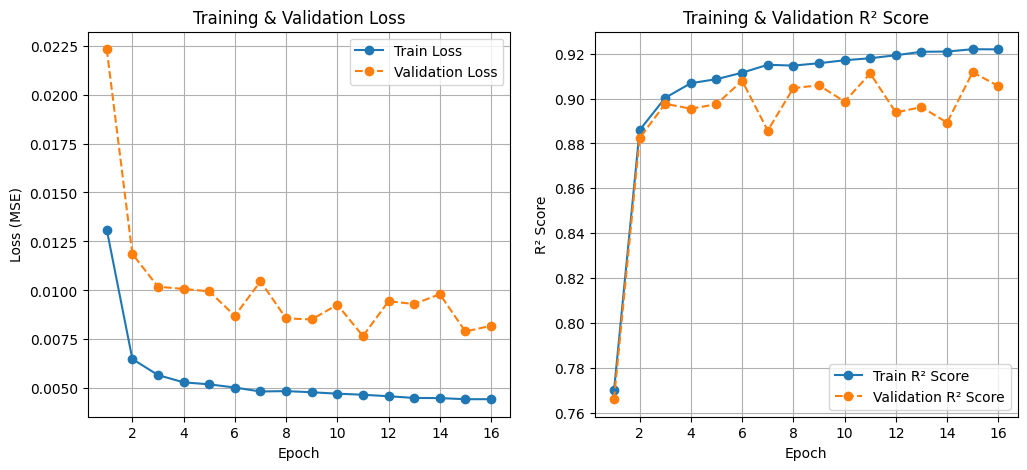

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', label="Train Loss") # 
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', linestyle='--', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# Plot R² Score
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_r2_scores) + 1), train_r2_scores, marker='o', linestyle='-', label="Train R² Score")
plt.plot(range(1, len(val_r2_scores) + 1)), val_r2_scores, marker='o', linestyle='--', label="Validation R² Score")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Training & Validation R² Score")
plt.legend()
plt.grid(True)

plt.show()

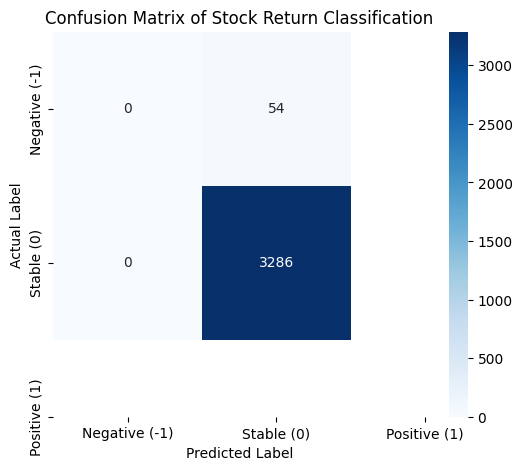

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.98      1.00      0.99      3286

    accuracy                           0.98      3340
   macro avg       0.49      0.50      0.50      3340
weighted avg       0.97      0.98      0.98      3340



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define threshold for classifying stock returns
threshold = 0.01  # Modify based on volatility

# Convert actual values into classes
def classify_stock_returns(values, threshold=0.01):
    return np.where(values > threshold, 1, np.where(values < -threshold, -1, 0))

# Convert actual & predicted returns into classes
actual_classes = classify_stock_returns(np.array(all_val_targets), threshold)
predicted_classes = classify_stock_returns(np.array(all_val_preds), threshold)

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative (-1)", "Stable (0)", "Positive (1)"],
            yticklabels=["Negative (-1)", "Stable (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of Stock Return Classification")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(actual_classes, predicted_classes))

In [16]:
def reset_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM) or isinstance(m, nn.Embedding):
        m.reset_parameters()  # Reinitialize weights

model.apply(reset_weights)  # Reset all model weights

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Reinitialize optimizer

model.train()  # Enable dropout & batch normalization layers

StockLSTM(
  (embedding): Embedding(547, 24)
  (lstm): LSTM(39, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [46]:
torch.save(model.state_dict(), "trained_stock_lstm_2.pth")
print("\nModel saved!")


Model saved!


To test one company

In [30]:
# CSCO
# Testing (Predict Dec 2023 & Compare to Actual)

test_company = input("\nEnter company name for testing: ")
df_train, df_test = load_company_data(test_company)
# input above
#  intrinsic_value  stock_exret     be_me     ni_me    fcf_me
#  betadown_252d    ni_ar1   z_score  ebit_sale  at_turnover  market_equity
#  roic          bvps  bvps_change  at_turnover_change  sin_month  cos_month (17 columns)

print(df_test)

# df_test is already processed because of load_company_data

if df_test is None or df_test.empty:
    print(f" No test data available for {test_company}.")
else:
    latest_financials = df_test.iloc[-1].to_dict()

    input_df = pd.DataFrame([latest_financials], columns=FEATURE_COLUMNS)

    input_df = input_df.drop(columns=["year", "month", "stock_ticker", "comp_name", "ni_me_change", "fcf_me_change",
    "prev_intrinsic_value","next_intrinsic_value","prev_stock_exret","next_stock_exret","prev_be_me",
    "next_be_me","prev_ni_me","next_ni_me","prev_fcf_me","next_fcf_me","prev_betadown_252d",
    "next_betadown_252d","prev_ni_ar1","next_ni_ar1","prev_z_score","next_z_score","prev_ebit_sale",
    "next_ebit_sale","prev_at_turnover","next_at_turnover","prev_market_equity","next_market_equity"
    ,"prev_bvps","next_bvps","sin_month","cos_month"
    ], errors="ignore")
    
    input_df = input_df.fillna(0)  # in case
    # input_df = normalize_features(input_df)
    print(input_df)
    
    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).unsqueeze(0).to(device)

    print(input_tensor.shape) # torch.Size([1, 1, 19])
    
    test_company_id = torch.tensor([company_to_id[test_company]], dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        predicted_return = model(input_tensor, test_company_id).item()

    actual_return = df_test["stock_exret"].values[0]

    print(f"\nPredicted: {predicted_return:.4f} | Actual: {actual_return:.4f}")

     year  month  intrinsic_value  stock_exret     be_me     ni_me    fcf_me  \
0    2000      1     26329.387270    -0.102689  0.115350  0.044278  0.030367   
1    2000      2     25538.357766     0.009136  0.133237  0.048106  0.039486   
2    2000      3     25538.357766     0.061588  0.131470  0.047468  0.038962   
3    2000      4     25538.357766     0.093162  0.122470  0.044218  0.036295   
4    2003      5     26916.225719     0.095580  0.167888  0.043980  0.045442   
..    ...    ...              ...          ...       ...       ...       ...   
247  2023      8     50189.967621    -0.080221  0.191170  0.029980  0.035243   
248  2023      9     50189.967621    -0.063095  0.207260  0.032503  0.038209   
249  2023     10     50189.967621    -0.023182  0.220207  0.034533  0.040596   
250  2023     11     43669.410539     0.098614  0.226563  0.031455  0.033447   
251  2023     12     43669.410539     0.051122  0.205320  0.028505  0.030311   

     betadown_252d    ni_ar1   z_score 

To test on multiple companies and find average (compare to baseline model)

In [52]:
# company files
company_files = [f.split(".csv")[0] for f in os.listdir("data") if f.endswith(".csv")]  # 2501 companies
company_to_id = {comp: idx for idx, comp in enumerate(company_files)}

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model = StockLSTM(input_size, hidden_size, num_layers, output_size, len(company_files), embedding_dim, num_heads).to(device)
# model.load_state_dict(torch.load("trained_stock_lstm.pth", map_location=device))

all_X_test = []
all_Y_test = []
all_company_ids_test = []

for test_company in company_files:
    company_id = company_to_id[test_company]
    
    df_train, df_val, df_test = load_company_data(test_company)    

    if df_test is None or df_test.empty:
        print(f"No test data available for {test_company}.")
        continue  # Skip if no test data

    # Extract latest financial data (last row)
    latest_financials = df_test.iloc[-1].to_dict()
    
    # Select only relevant features
    input_df = pd.DataFrame([latest_financials], columns=FEATURE_COLUMNS)

    input_df = input_df.drop(columns=["year", "month", "stock_ticker", "comp_name", "ni_me_change", "fcf_me_change",
        "prev_intrinsic_value", "next_intrinsic_value", "prev_stock_exret", "next_stock_exret", "prev_be_me",
        "next_be_me", "prev_ni_me", "next_ni_me", "prev_fcf_me", "next_fcf_me", "prev_betadown_252d",
        "next_betadown_252d", "prev_ni_ar1", "next_ni_ar1", "prev_z_score", "next_z_score", "prev_ebit_sale",
        "next_ebit_sale", "prev_at_turnover", "next_at_turnover", "prev_market_equity", "next_market_equity",
        "prev_bvps", "next_bvps", "sin_month", "cos_month"
    ], errors="ignore")

    # Fill NaN values
    input_df = input_df.fillna(0)

    # Convert to tensor
    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 1, num_features)

    # Store data for batch processing
    all_X_test.append(input_tensor)
    all_Y_test.append(torch.tensor(df_test["stock_exret"].values[-1], dtype=torch.float32).unsqueeze(0))
    all_company_ids_test.append(torch.tensor([company_id], dtype=torch.long))

# Combine into batch tensors
X_test_tensor = torch.cat(all_X_test, dim=0).to(device)  # Shape: (num_samples, 1, num_features)
Y_test_tensor = torch.cat(all_Y_test, dim=0).to(device)  # Shape: (num_samples, 1)
company_test_tensor = torch.cat(all_company_ids_test, dim=0).to(device)  # Shape: (num_samples,)

# Evaluate Model on Test Data
model.eval()
all_preds = []

with torch.no_grad():
    predictions = model(X_test_tensor, company_test_tensor).squeeze()
    all_preds = predictions.cpu().numpy()
    all_targets = Y_test_tensor.cpu().numpy()

# Compute Test Metrics
test_loss = criterion(predictions, Y_test_tensor).item()
r2 = r2_score(all_targets, all_preds)
mape = np.mean(np.abs((all_targets - all_preds) / (all_targets + 1e-8))) * 100  # Avoid division by zero

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAPE: {mape:.2f}%")


No test data available for BA.
No test data available for MSCI.
No test data available for HCA.
No test data available for GWRE.
No test data available for WU.
No test data available for LNC.
No test data available for LNG.
No test data available for TDG.
No test data available for LOW.
No test data available for AIZ.
No test data available for SBUX.
No test data available for MCD.
No test data available for VRSN.
No test data available for HPQ.
No test data available for MTCH.
No test data available for JEF.
No test data available for AZO.
No test data available for BEN.
No test data available for SIRI.
No test data available for VEEV.
No test data available for MAS.
No test data available for OMF.
No test data available for PM.
No test data available for CAH.
No test data available for LEN.
No test data available for LII.
No test data available for FICO.
No test data available for MCK.
No test data available for AAL.
No test data available for CNA.
No test data available for YUM.
No 